
### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики точность (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [25]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

In [26]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy


def IG(r, r_left, r_right):
    if entropy(r) == 0:
        return 0
    return entropy(r) - (entropy(r_left) * len(r_left) / len(r) + entropy(r_right) * len(r_right) / len(r))


def split_vector(predicate, dataframe):
    return dataframe[predicate(dataframe)], dataframe[np.invert(predicate(dataframe))]

In [27]:
class Node(object):
    def __init__(self, predicate):
        self.predicate = predicate
        self.left_child = None
        self.right_child = None


class Leaf(object):
    def __init__(self, value, probs):
        self.value = value
        self.propabilities = probs

In [28]:
class DecisionTree(BaseEstimator):

    def __init__(self, criterion='purity', criterion_value=5):
        self.X, self.Y = None, None
        self.Node = None
        self.criterion = criterion
        self.criterion_value = criterion_value

    def fit(self, X, y):
        self.X = np.column_stack((X, y))
        self.build_root()

    def find_predicate(self, X):
        max_ig = 0
        best_predicate = None
        best_left = None
        best_right = None
        for feature in range(X.shape[1] - 1):
            for value in np.linspace(X[:, feature].min(), X[:, feature].max(), 20):
                predicate = (feature, value)
                left, right = split_vector(lambda x: x[:, feature] < value, X)
                temp_IG = IG(X[:, -1], left[:, -1], right[:, -1])
                if temp_IG > max_ig:
                    max_ig = temp_IG
                    best_predicate = predicate
                    best_left = left
                    best_right = right
        return best_predicate, max_ig, best_left, best_right

    def build_root(self):
        predicate, ig, X_left, X_right = self.find_predicate(self.X)
        self.Node = Node(predicate)
        self.Node.left_child = self.build_tree(X_left, 1)
        self.Node.right_child = self.build_tree(X_right, 1)

    def build_tree(self, X, current_depth):
        predicate, ig, X_left, X_right = self.find_predicate(X)
        if ig == 0:
            probs = {0: 0, 1: 0, 2: 0}
            for i in X[:, -1]:
                probs[i] += 1 / len(X)
            return Leaf(pd.Series(X[:, -1]).mode()[0], probs)
        node = Node(predicate)
        if self.criterion_checker(X, X_left, X_right, current_depth):
            node.left_child = self.build_tree(X_left, current_depth + 1)
            node.right_child = self.build_tree(X_right, current_depth + 1)
            return node
        else:
            probs = {0: 0, 1: 0, 2: 0}
            for i in X[:, -1]:
                probs[i] += 1 / len(X)
            return Leaf(pd.Series(X[:, -1]).mode()[0], probs)

    def criterion_checker(self, X, X_left, X_right, depth):
        if self.criterion == 'max_depth':
            if depth < self.criterion_value:
                return True
            else:
                return False
        if self.criterion == 'min_leaf_size':
            if len(X_left) < self.criterion_value or len(X_right) < self.criterion_value:
                return False
            else:
                return True
        if self.criterion == 'purity':
            if np.unique(X[:, -1]).size == 1:
                return False
            else:
                return True

    def predict(self, X_test):
        answers = []
        for sample in X_test:
            dec_value, _ = self.decision(np.array([sample]), self.Node)
            answers.append(dec_value)
        answers = np.array(answers)
        return answers

    def predict_proba(self, X_test):
        probabilities = []
        for sample in X_test:
            _, dec_proba = self.decision(np.array([sample]), self.Node)
            probabilities.append(dec_proba)
        probabilities = np.array(probabilities)
        return probabilities

    def decision(self, sample, node):
        if isinstance(node, Leaf):
            return node.value, node.propabilities
        else:
            if sample[:, node.predicate[0]] < node.predicate[1]:
                return self.decision(sample, node.left_child)
            else:
                return self.decision(sample, node.right_child)


In [29]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
cv = GridSearchCV(DecisionTree(),
                  {'criterion': ['max_depth', 'min_leaf_size', 'purity'], 'criterion_value': range(1, 6)},
                  scoring='accuracy')
cv.fit(X_train, y_train)
accuracy_score(y_test, cv.best_estimator_.predict(X_test))

0.96

In [30]:
dt = DecisionTree(criterion='max_depth')
dt.fit(X_train, y_train)
probs=dt.predict_proba(X_test)

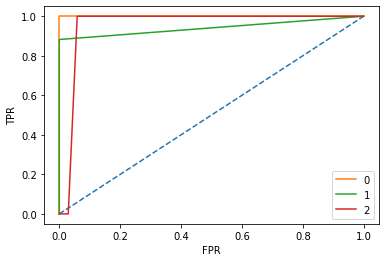

In [31]:
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(np.linspace(0, 1), np.linspace(0, 1), linestyle='--')
for i in range(3):
    probs_i = [probs[j][i] for j in range(len(X_test))]
    x, y, _ = roc_curve(y_test, probs_i, pos_label=i)
    plt.plot(x, y, label=i)
plt.legend(loc='best')

In [32]:
dt = DecisionTree(criterion='max_depth')
dt.fit(X_train, y_train)
accuracy_score(y_test, dt.predict(X_test))

0.96

In [33]:
dt = DecisionTree(criterion='min_leaf_size')
dt.fit(X_train, y_train)
accuracy_score(y_test, dt.predict(X_test))

0.94

In [34]:
dt = DecisionTree(criterion='purity')
dt.fit(X_train, y_train)
accuracy_score(y_test, dt.predict(X_test))

0.96

### Задание №2
В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов.
Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.
Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма.
Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [35]:
churn = pd.read_csv("churn.csv", sep=',')
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Проведем предобработку данных. Категориальные переменные принимают небольшое количество значений, можем воспользоваться методом One Hot encoding.

In [36]:
for value in churn['Gender'].unique():
    churn.loc[churn['Gender'] == value, value] = 1
    churn.loc[churn['Gender'] != value, value] = 0
for value in churn['Geography'].unique():
    churn.loc[churn['Geography'] == value, value] = 1
    churn.loc[churn['Geography'] != value, value] = 0
churn.drop(['Geography', 'Gender'], axis=1, inplace=True)
churn

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Female,Male,France,Spain,Germany
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,1.0,0.0,0.0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,1.0,0.0,0.0,1.0,0.0
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,1.0,0.0,0.0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,1.0,0.0,0.0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,39,5,0.00,2,1,0,96270.64,0,0.0,1.0,1.0,0.0,0.0
9996,9997,15569892,Johnstone,516,35,10,57369.61,1,1,1,101699.77,0,0.0,1.0,1.0,0.0,0.0
9997,9998,15584532,Liu,709,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,1.0,0.0,0.0
9998,9999,15682355,Sabbatini,772,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0,0.0,1.0


In [37]:
y = np.array(churn['Exited'])
churn.drop('Exited', axis=1, inplace=True)
df_X = churn.iloc[:, 3:]
X = np.array(df_X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67)

In [38]:
class RandomForest(BaseEstimator):
    def __init__(self, N=100, criterion='max_depth', criterion_value=10, max_features='sqrt'):
        self.N = N
        self.criterion = criterion
        self.criterion_value = criterion_value
        self.X, self.y = None, None
        self.samples, self.answers = None, None
        self.max_features = max_features
        self.trees, self.feature_importances = None, None

    def fit(self, X, y):
        self.X = X
        self.y = y

        self.samples = []
        self.answers = []
        for i in range(self.N):
            indicies = np.random.choice(len(X) - 1, len(X))
            self.samples.append(self.X[indicies])
            self.answers.append(self.y[indicies])
        if self.criterion == 'max_depth':
            self.trees = [DecisionTreeClassifier(max_depth=self.criterion_value,
                                                 max_features=self.max_features) for _ in range(self.N)]
        if self.criterion == 'min_leaf_size':
            self.trees = [DecisionTreeClassifier(min_samples_leaf=self.criterion_value,
                                                 max_features=self.max_features) for _ in range(self.N)]
        for i in range(self.N):
            self.trees[i].fit(self.samples[i], self.answers[i])

    def predict(self, X):
        pred = []
        for i in range(self.N):
            pred.append(self.trees[i].predict(X))
        return np.round(np.mean(pred, axis=0))

    def predict_proba(self, X):
        pred = np.zeros((len(X), 2))
        for i in range(self.N):
            pred += self.trees[i].predict_proba(X)
        pred /= self.N
        return pred

    def get_feature_importances(self):
        self.feature_importances = {feature_name: 0 for feature_name in range(self.X.shape[1])}
        for tree_num in range(self.N):
            tree = self.trees[tree_num]
            sample = self.samples[tree_num]

            tree_feature_importances = tree.feature_importances_
            for i in range(sample.shape[1]):
                self.feature_importances[i] += tree_feature_importances[i]
        return list(self.feature_importances.items())

In [39]:
cv = GridSearchCV(RandomForest(),
                  {'criterion': ['max_depth', 'min_leaf_size'], 'criterion_value': [1, 5, 10, 15, 20, 25, 30]},
                  scoring='accuracy')
cv.fit(X_train, y_train)
print(accuracy_score(y_test, cv.predict(X_test)))
cv.best_params_

0.8687878787878788


{'criterion': 'max_depth', 'criterion_value': 10}

In [40]:
rfc=RandomForest(criterion='max_depth', criterion_value=10)
rfc.fit(X_train, y_train)
features_tmp=rfc.get_feature_importances()
features={}
for feature in features_tmp:
    features[df_X.columns[feature[0]]]=feature[1]
features

{'CreditScore': 8.966789750406422,
 'Age': 30.102037473851546,
 'Tenure': 5.0712945865711685,
 'Balance': 11.27744199033419,
 'NumOfProducts': 20.869963946415147,
 'HasCrCard': 1.3006418601831462,
 'IsActiveMember': 5.870381775219255,
 'EstimatedSalary': 8.165602907670479,
 'Female': 1.2282479757928797,
 'Male': 1.0786396743809095,
 'France': 1.2383685620789642,
 'Spain': 0.8981912558005423,
 'Germany': 3.9323982412953633}

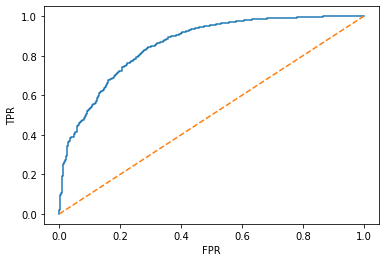

In [41]:
rfc = RandomForest(criterion='max_depth', criterion_value=10)
rfc.fit(X_train, y_train)
probs = rfc.predict_proba(X_test)
tpr, fpr, _ = roc_curve(y_test, probs[:, 0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), linestyle='--')